# LOAD Modules

In [1]:
%matplotlib inline
#%matplotlib widget
%load_ext autoreload
%autoreload 2


import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot, curve_name_gen
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics, final_test_acc
from configs import configs_ozhan, configs_tim, configs_joaquin
from data_loader_creation import get_dataloader_objects
from classification_results import results_storer
from datetime import datetime
import torch

# Select the configuration

In [2]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
#myList = configs_tim.list_of_configs
#myList = configs_joaquin.list_of_configs
myList = configs_ozhan.list_of_configs

# Train

ConvNetOzhan3D_Adam 
-------------------------

We are not on the cluster...

Data is being loaded using MNE...


100%|██████████| 4/4 [00:19<00:00,  4.85s/it]


3600 matching events found
No baseline correction applied
...data loading with MNE was finished. 

Dataset is being made 2D...
Data is now 2D.

Normalizing data...
...data was normalized.

Dataset is being cropped in time axis...
Dataset is cropped. From shape (3600, 10, 11, 320) to (226800, 10, 11, 10) 

10  time samples and  10  EEG channels for one epoch are taken.  Total epoch number is  226800  and there are  20  subjects included.
 There are in total  8  classes for classification.


Expected network layer output shapes:
Input: [1, 11, 10, 10]
Layer 1 Out: [32, 11, 10, 10]
Layer 2 Out: [64, 11, 10, 10]
Layer 3 Out: [128, 11, 10, 10]
Linear Layer Features: 140800 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001 

-> Epoch 1/50: train_loss: 3.4125, train_accuracy: 18.8043%, val_loss: 2.1256, val_accuracy: 24.3827%
-> Epoch 2/50: train_loss: 2.2492, train_accuracy: 29.8893%, val_loss: 1.9251, val_accuracy: 36.2238%
-> Epoch 3/50: tr

100%|██████████| 4/4 [00:19<00:00,  4.85s/it]


3600 matching events found
No baseline correction applied
...data loading with MNE was finished. 

Normalizing data...
...data was normalized.

Dataset is being cropped in time axis...
Dataset is cropped. From shape (3600, 64, 320) to (226800, 64, 10) 

10  time samples and  64  EEG channels for one epoch are taken.  Total epoch number is  226800  and there are  20  subjects included.
 There are in total  8  classes for classification.


Expected network layer output shapes:
Input: [1, 64, 10]
Layer 1 Out: [32, 64, 10]
Layer 2 Out: [64, 64, 10]
Layer 3 Out: [128, 64, 10]
Linear Layer Features: 81920 

cuda will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  0.001 

-> Epoch 1/50: train_loss: 2.6569, train_accuracy: 21.8287%, val_loss: 1.9809, val_accuracy: 30.2959%
-> Epoch 2/50: train_loss: 1.8961, train_accuracy: 33.8837%, val_loss: 1.6739, val_accuracy: 40.2165%
-> Epoch 3/50: train_loss: 1.5570, train_accuracy: 43.0183%, val_loss: 1.4435, val_accu

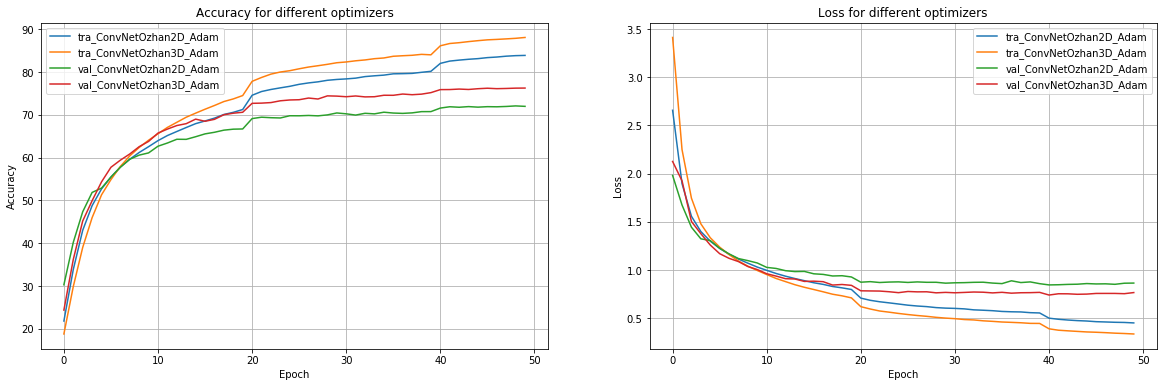

In [3]:
training_curves = {}

for my_cfg in myList:
    
    curve_name_gen(my_cfg)
    
    """ PREPARE DATALOADERS """
    train_dl, val_dl, test_dl, input_dimension_, output_dimension_ = get_dataloader_objects(my_cfg)

    
    """CLASSIFICATION"""
    # Get the model
    model_untrained = get_nn_model(my_cfg, input_dimension=input_dimension_,output_dimension=output_dimension_)

    # Get the optimizer
    optimizer = get_optimizer(my_cfg, model_untrained.parameters())

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg)
    
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    training_curves[my_cfg.curve_name] = curves
    
    # Report final accuracy
    test_loss, test_accuracy =  final_test_acc(model_trained, test_dl, my_cfg)
    
    # Save the model
    todays_date = datetime.today().strftime('%Y%m%d_%H%M%S')
    todays_date = 'TrainedModel/'+todays_date
    todays_date_all = todays_date + '_all'
    torch.save(model_trained.state_dict(), todays_date)
    torch.save(model_trained, todays_date_all)

    # Store the results
    results_storer.store_results_for_plot(my_cfg,test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)

    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies, test_dl)


plot_all_metrics(training_curves)

In [ ]:
import matplotlib.pyplot as plt
plot_all_metrics(training_curves)
plt.savefig('Res.eps', format='eps')
